In [1]:
import itertools

import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.metrics import confusion_matrix


## Loading the MNIST dataset

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize images to [0, 1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

# make sure images have shape (28, 28, 1). Note: -1 means expand on final axis
# x_train, x_test = np.expand_dims(x_train., -1), np.expand_dims(x_test, -1)


## Visualizing the images

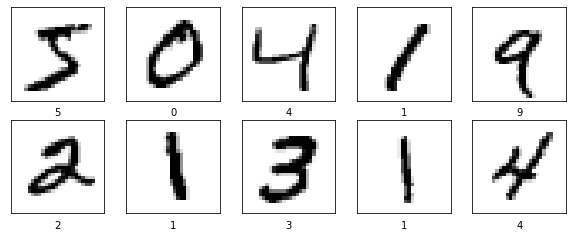

In [4]:
classes = range(10)

plt.figure(figsize=(10,10))

for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(classes[y_train[i]])

plt.show()

In [20]:
# Flatten image matrix to feature vector
x = x_train.reshape((x_train.shape[0], -1)) # -1 means infer dim. so it will find 28*28=784 
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1) 
x_train.shape


(60000, 784)

## Creating the model

In [22]:
model = models.Sequential()

model.add(layers.Dense(32, input_dim=784, activation='sigmoid'))
model.add(layers.Dense(16,activation='sigmoid'))
model.add(layers.Dense(10)) # have 10 classes (labels)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                25120     
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 10)                170       
                                                                 
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
_________________________________________________________________


### What is Dropout?

In machine learning a number of techiques exist to prevent overfitting. This is known as **regularization** with traditional methods such as L1 and L2 ([see here for more info](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)). 

However, one type of overfitting can not be corrected by L1 and L2, known as **co-adaptation**.

As a network trains, it is likely that some neurons in the network will yield more predictive power than others. As the training iterates, such neurons only become more stronger while the weaker ones are neglected. As a result only a fraction of the neurons in the network participate in the training. 

Dropout is a regularization technique that prevents co-adaption. During training at each iteration a set of neurons are temporary omitted. For more information about the math behind dropout please refer to the following article [here](https://towardsdatascience.com/simplified-math-behind-dropout-in-deep-learning-6d50f3f47275). Additionally, the following white paper is also worth a look [here](https://jmlr.org/papers/v15/srivastava14a.html)

![Srivastava, Nitish, et al. ”Dropout: a simple way to prevent neural networks from
overfitting”, JMLR 2014](https://miro.medium.com/max/2400/1*iWQzxhVlvadk6VAJjsgXgg.png)

## Train the model

In [37]:
model.compile(
    optimizer="sgd", # stochastic gradient descent
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # See comment below for more info
    metrics=['accuracy']
)

# Logits: The vector of raw (non-normalized) predictions that a classification model generates.
# Cross Entropy: see https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

epochs = 10

fit = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

history = fit.history

model.save('my_model')
np.save('my_history.npy', history)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.6965 - accuracy: 0.6827 - val_loss: 1.3014 - val_accuracy: 0.7553
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9956 - accuracy: 0.8312 - val_loss: 0.7710 - val_accuracy: 0.8599
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6540 - accuracy: 0.8724 - val_loss: 0.5669 - val_accuracy: 0.8800
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5140 - accuracy: 0.8902 - val_loss: 0.4662 - val_accuracy: 0.8955
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4362 - accuracy: 0.9016 - val_loss: 0.4090 - val_accuracy: 0.9046
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3909 - accuracy: 0.9077 - val_loss: 0.3733 - val_accuracy: 0.9096
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3609 - accuracy: 0.9116 - val_loss: 0.3490 - val_accuracy

## Evaluate

In [31]:
# Run this cell if you want to load a prev trained model
model = models.load_model("my_model")
history = np.load('my_history.npy', allow_pickle=True).item()

### Loss

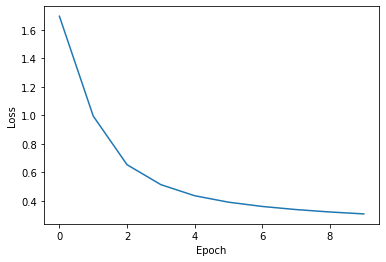

In [38]:
plt.plot(history['loss'], label='training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Accuracy

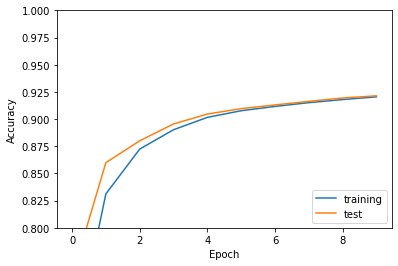

In [39]:
plt.plot(history['accuracy'], label='training')
plt.plot(history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.show()

### Confusion matrix

In [40]:

def plot_confusion_matrix(y_test,
                          y_predict,
                          classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test, y_predict)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

313/313 [==============================] - 1s 2ms/step


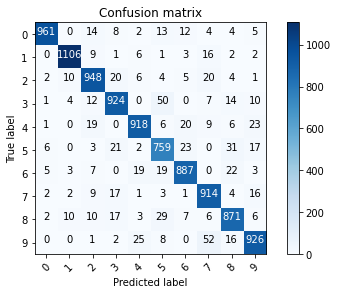

In [41]:
classes = range(10)

predictions = model.predict(x_test)

predictions = [np.argmax(p) for p in predictions]
plot_confusion_matrix(predictions, y_test, classes, normalize=False)

In [42]:
score = model.evaluate(x_train, y_train, verbose=0)
print('---------- Training ----------')
print("loss:", round(score[0], 4))
print("accuracy:", round(score[1], 4))

score = model.evaluate(x_test, y_test, verbose=0)
print('----------   Test   ----------')
print("loss:", round(score[0], 2))
print("accuracy:", round(score[1], 4))

---------- Training ----------
loss: 0.3018
accuracy: 0.9219
----------   Test   ----------
loss: 0.3
accuracy: 0.9214
